## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)
from tqdm.auto import tqdm
import seaborn as sns
import os
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


OUTPUT_DIR_NAME = './output'

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv('./data/data.csv')

In [4]:
df

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
5,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
6,34554026,Accessing pointer member of the structure usin...,<p>I have defined integer pointer inside the s...,<c><pointers><data-structures>,2016-01-01 06:21:17,LQ_CLOSE
7,34554206,"How To Disable 2nd Saturday 4th Saturday ,Sund...","i want to Disable 2nd Saturday 4th saturday,...",<javascript><jquery><jquery-ui>,2016-01-01 06:55:18,LQ_EDIT
8,34554671,Resizing containers in bootstrap,I am new to bootstrap and i would like to find...,<jquery><html><css><twitter-bootstrap>,2016-01-01 08:32:05,LQ_EDIT
9,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT


In [5]:
df = df.rename(columns={"Y": "QualityRating"})
df

,Id,Title,Body,Tags,CreationDate,TypeQ
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
5,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
6,34554026,Accessing pointer member of the structure usin...,<p>I have defined integer pointer inside the s...,<c><pointers><data-structures>,2016-01-01 06:21:17,LQ_CLOSE
7,34554206,"How To Disable 2nd Saturday 4th Saturday ,Sund...","i want to Disable 2nd Saturday 4th saturday,...",<javascript><jquery><jquery-ui>,2016-01-01 06:55:18,LQ_EDIT
8,34554671,Resizing containers in bootstrap,I am new to bootstrap and i would like to find...,<jquery><html><css><twitter-bootstrap>,2016-01-01 08:32:05,LQ_EDIT
9,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
Id              60000 non-null int64
Title           60000 non-null object
Body            60000 non-null object
Tags            60000 non-null object
CreationDate    60000 non-null object
TypeQ           60000 non-null object
dtypes: int64(1), object(5)
memory usage: 2.7+ MB


In [7]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,60000,NaN,NaN,NaN,4.57574e+07,7.12473e+06,3.45527e+07,3.97528e+07,4.50328e+07,5.12713e+07,6.04703e+07
Title,60000,59995,Regular expression,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Body,60000,60000,<p>What is the keyboard shortcut navigate back...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tags,60000,33224,<python>,1068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreationDate,60000,59981,2018-09-11 13:25:40,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TypeQ,60000,3,LQ_EDIT,20000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Пропуски в процентах

In [8]:
(df.isnull().sum() / len(df)) * 100

Id              0.0
Title           0.0
Body            0.0
Tags            0.0
CreationDate    0.0
TypeQ           0.0
dtype: float64

## Удаление лишних столбцов

In [9]:
del df["Id"]
del df["Title"]
del df["CreationDate"]

In [10]:
df.head(3)

,Body,Tags,TypeQ
0,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE
1,I am having 4 different tables like \r\nselect...,<sql><sql-server>,LQ_EDIT
2,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ


In [11]:
df.describe().T

,count,unique,top,freq
Body,60000,60000,<p>What is the keyboard shortcut navigate back...,1
Tags,60000,33224,<python>,1068
TypeQ,60000,3,LQ_EDIT,20000


In [12]:
df["Body"][0]

'<p>I\'m already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print "Hello World" to the console every random seconds from 1-5. Unfortunately I\'m in a bit of a rush and don\'t have any code to show so far. Any help would be apriciated.  </p>\n'

## Предобработка данных

In [13]:
def remove_opened_closed_tag(text: str='') -> str:
    """Remove opened and closed tag (example <p></p>)"""
    return re.sub(fr'<[{string.ascii_letters}]*>|<\/[{string.ascii_letters}]*>', '', text, flags=re.MULTILINE)

def remove_beaks(text: str='') -> str:
    """Remove '<' or '>'"""
    return re.sub(r'<|>', ' ', text, flags=re.MULTILINE)

def remove_punctuation(text: str='') -> str:
    return text

def remove_stopword(text: str='') -> str:
    return text

def remove_line_breaks(text: str='') -> str:
    return text.replace('\n', '\r').replace('\r', ' ')

def to_lowercase(text: str='') -> str:
    return text.lower()

def preprocess(text: str='') -> str:
    functions = [
        to_lowercase,
        remove_opened_closed_tag,
        remove_beaks,
        remove_punctuation,
        remove_stopword,
        remove_line_breaks,
    ]
    

    for func in functions:
        text = func(text)
    return text


In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
tags = df.Tags.apply(remove_beaks)
tags

0                                            java  repeat 
1                                         sql  sql-server 
2                                          java  optional 
3         javascript  image  overlay  react-native  opa...
4         swift  operators  whitespace  ternary-operato...
5         android  material-design  floating-action-but...
6                            c  pointers  data-structures 
7                           javascript  jquery  jquery-ui 
8                    jquery  html  css  twitter-bootstrap 
9                    php  mysql  sql  codeigniter  mysqli 
10        c#  windows-10  windows-10-mobile  windows-10...
11                                                    vb6 
12                                         python  pandas 
13                                     sql-server  c#-4.0 
14          linux  mongodb  ubuntu  ubuntu-14.04  startup 
15                                  android  android-file 
16                                                    ph

In [16]:
def tech(name):
    name = np.asarray(name.split(' '))
    return ' '.join(name[name != ''])

techs = tags.apply(tech).to_numpy()
techs

array(['java repeat', 'sql sql-server', 'java optional', ...,
       'django django-views django-templates', 'javascript php html',
       'c++ overloading return-type'], dtype=object)

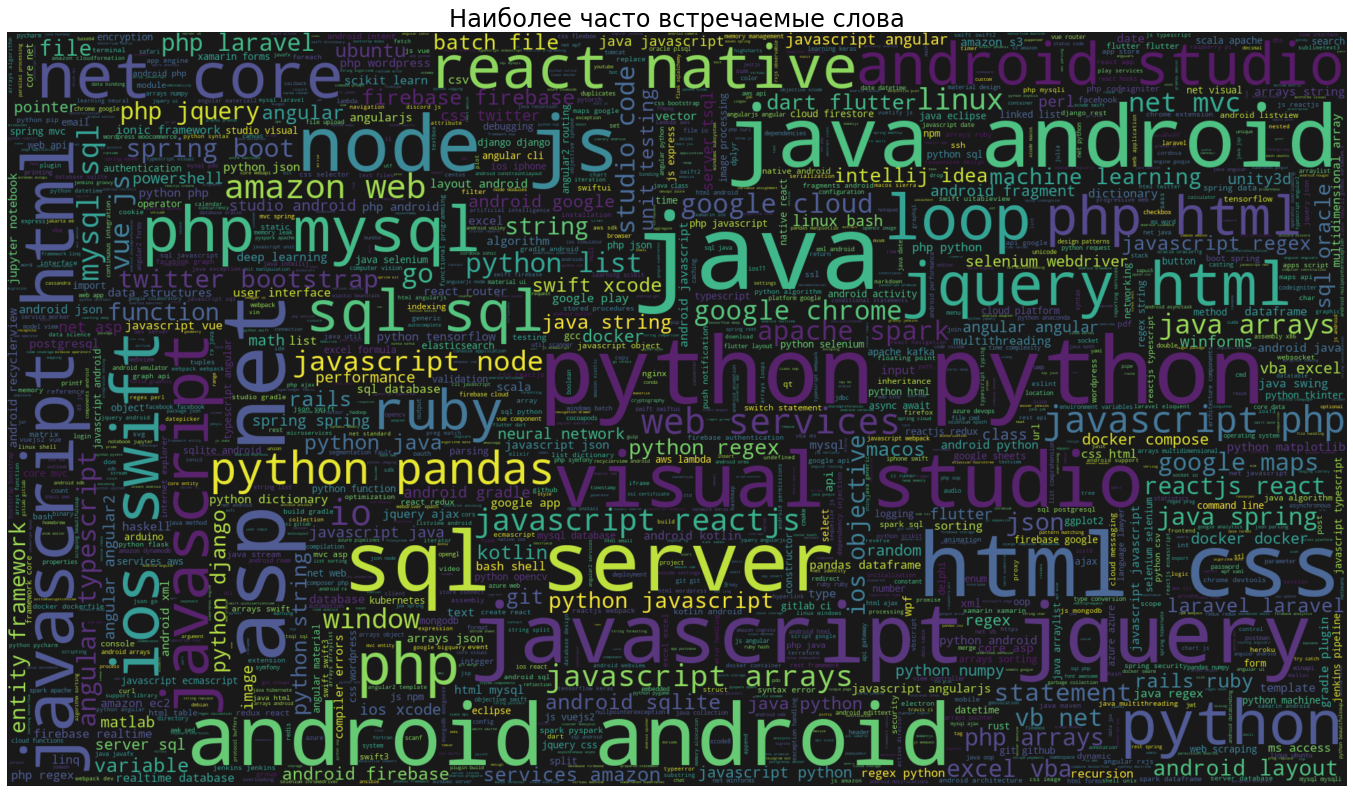

In [17]:
plt.figure(figsize=(24,24))
wc = WordCloud(background_color="black", max_words=1500, max_font_size=150,  width=1920, height=1080)
wc.generate(" ".join(techs))

plt.title("Наиболее часто встречаемые слова", fontsize=24)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=42), alpha=0.9, interpolation="bilinear", )
plt.axis('off')

if os.path.exists(f"{OUTPUT_DIR_NAME}/tech_all.png"):
    plt.savefig(f"{OUTPUT_DIR_NAME}/tech_all.png")

In [18]:
pd.DataFrame(np.asarray(" ".join(techs).split(' '))).describe().T

,count,unique,top,freq
0,159880,10703,javascript,7106


In [19]:
df["Body"][28]

"<pre><code>lt = ['7,777.7', '777.7', '77,777.7', '77.7']\n</code></pre>\n\n<p>How can I proceed to print the list content like this ?</p>\n\n<pre><code> 7,777.7\n   777.7\n77,777.7\n    77.7\n</code></pre>\n"

In [20]:
a = df["Body"].apply(preprocess)
a

0        i'm already familiar with repeating tasks ever...
1        i am having 4 different tables like   select *...
2        i'd like to understand why java 8 optionals we...
3        i am attempting to overlay a title over an ima...
4        the question is very simple, but i just could ...
5        i'm using custom floatingactionmenu. i need to...
6        i have defined integer pointer inside the stru...
7          i want to disable 2nd saturday 4th saturday,...
8        i am new to bootstrap and i would like to find...
9        i have two table m_master and tbl_appointment ...
10       i was able to change theme using this.requeste...
11       i my case i am having two form form 1 and form...
12       i'm trying to extract us states from wiki url,...
13       i'm so new to c#, i wanna make an application ...
14       i am new to ubuntu (linux tbh). i encountered ...
15       i am kinda new to android development, but i c...
16       basically i have this array:        array(  \t.

In [21]:
word_tokenize('ss sd ds asdasd asd as dadsasdas')

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Владислав Бакшанский/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Владислав Бакшанский\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [22]:
df["Body"]

0        <p>I'm already familiar with repeating tasks e...
1        I am having 4 different tables like \r\nselect...
2        <p>I'd like to understand why Java 8 Optionals...
3        <p>I am attempting to overlay a title over an ...
4        <p>The question is very simple, but I just cou...
5        <p>I'm using custom floatingactionmenu. I need...
6        <p>I have defined integer pointer inside the s...
7          i want to Disable 2nd Saturday 4th saturday,...
8        I am new to bootstrap and i would like to find...
9        I have two table m_master and tbl_appointment\...
10       <p>I was able to change theme using <code>this...
11       I my case I am having two form Form 1 and Form...
12       <p>I'm trying to extract US states from wiki U...
13       I'm so new to C#, I wanna make an application ...
14       <p>I am new to Ubuntu (Linux tbh). I encounter...
15       <p>I am kinda new to Android development, but ...
16       basically i have this array:\r\n\r\n    array(.